In [9]:
pip install shap

In [79]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTENC
from sklearn.inspection import permutation_importance
import shap
#from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [11]:
def Get_Data():
  df_xray = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/xray.pkl")
  df_clinical = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/clinical.pkl")
  df_mri = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/mri.pkl")
  df_questionnaires = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/questionnaires.pkl")
  df_tomography = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/tomography.pkl")
  df_biomarkers = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/biomarkers.pkl")
  df_progression = pd.read_csv('/content/drive/MyDrive/Dissertation Final/progression.csv')
  return(df_xray,df_clinical,df_mri,df_questionnaires,df_tomography,df_biomarkers,df_progression)

In [12]:
df_xray,df_clinical,df_mri,df_questionnaires,df_tomography,df_biomarkers,df_progression = Get_Data()

In [13]:
df_xray.shape

(297, 24)

In [14]:
df_mri.shape

(297, 133)

In [15]:
(df_xray.isnull().sum().sum()/df_xray.size)*100

1.3187429854096522

In [16]:
(df_mri.isnull().sum().sum()/df_mri.size)*100

3.6556036556036555

In [17]:
df_progression

,ID,S,P
0,1,0,0
1,5,0,0
2,7,1,1
3,11,0,1
4,12,0,1
...,...,...,...
218,424,0,0
219,426,1,0
220,432,0,1
221,433,0,0


<Axes: xlabel='S', ylabel='count'>

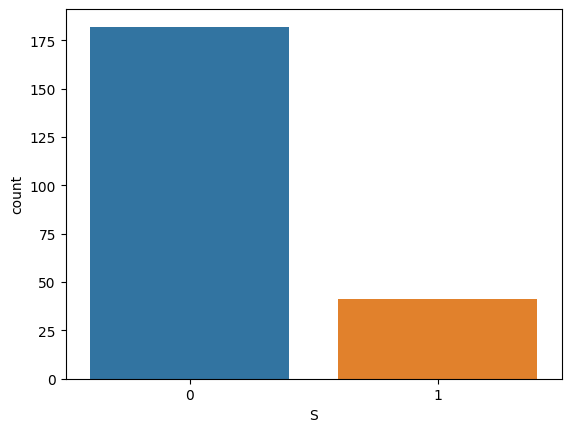

In [18]:
#Switch between 'S' and 'P' to see the class label distribution
sns.countplot(x=df_progression['S'])

In [19]:
df_progression['multiclass_labels'] = df_progression['P'] * 2 + df_progression['S']

In [20]:
df_progression

,ID,S,P,multiclass_labels
0,1,0,0,0
1,5,0,0,0
2,7,1,1,3
3,11,0,1,2
4,12,0,1,2
...,...,...,...,...
218,424,0,0,0
219,426,1,0,1
220,432,0,1,2
221,433,0,0,0


In [21]:
df_progression = df_progression.drop(['S','P'],axis =1)

In [22]:
df_progression, df_progression.shape


(      ID  multiclass_labels
 0      1                  0
 1      5                  0
 2      7                  3
 3     11                  2
 4     12                  2
 ..   ...                ...
 218  424                  0
 219  426                  1
 220  432                  2
 221  433                  0
 222  434                  3
 
 [223 rows x 2 columns],
 (223, 2))

In [23]:
df_progression['multiclass_labels'].value_counts()

0    115
2     67
1     30
3     11
Name: multiclass_labels, dtype: int64

In [24]:
def Join_DataSets(df1,df2):
  return(df1.join(df2))

In [25]:
joined_df = Join_DataSets(df_biomarkers, df_clinical)

In [26]:
joined_df.shape

(295, 54)

In [27]:
id_sub = df_xray.index
output = {n: int(str(n)[-3:]) for n in id_sub}

In [28]:
dic_reversed = {v: k for k, v in output.items()}
df_progression['Key'] = df_progression['ID'].map(dic_reversed)
df_progression['Key'] = df_progression['Key'].replace({np.nan: 'NaN'})

In [29]:
df_progression = df_progression.drop(['ID'],axis =1)

In [30]:
merged_df = pd.merge(df_progression, joined_df , left_on='Key', right_on='Subject ID')

In [31]:
merged_df = merged_df.drop(['Key'],axis =1)

#**Exploratory Data Analysis**

In [32]:
merged_df.shape

(221, 55)

In [33]:
merged_df['multiclass_labels'].value_counts()

0    114
2     66
1     30
3     11
Name: multiclass_labels, dtype: int64

<Axes: xlabel='multiclass_labels', ylabel='count'>

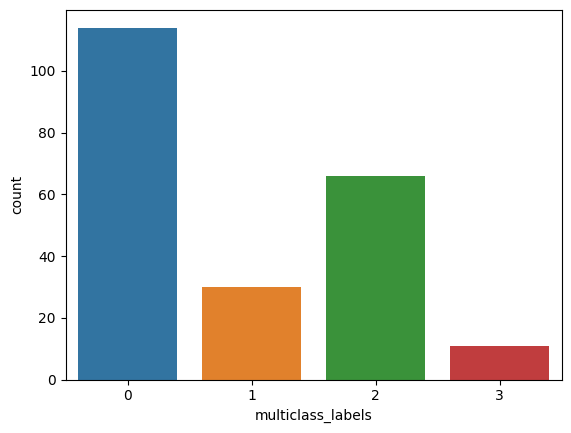

In [34]:
sns.countplot(x=merged_df['multiclass_labels'])

In [35]:
merged_df.isnull().sum()

multiclass_labels                   0
S_C3M                               0
S_CRPM                              0
S_CTXI                              0
S_HA                                0
S_hsCRP                             0
S_hsPRO_C2                          0
S_ARGS_LUND                         0
S_NMID                              0
S_COMP                              0
U_CTXII_CREA                        0
U_CTXIALPHA_CREA                    0
S_C2M                               0
S_RE_C1M                            0
S_C10C                              0
S_COLL2_1                           0
S_COLL2_1NO2                        0
BP_DBP_mean                         0
BP_HR_mean                          0
BP_SBP_mean                         0
Chair_StandUp_Stands                3
Chair_StandUp_Strategy              0
Menopause_Post                      1
Painful_Hip                        18
Self_Paced_Walk_Aid                 0
Med_His_OA                          0
PE_Doyle_Ind

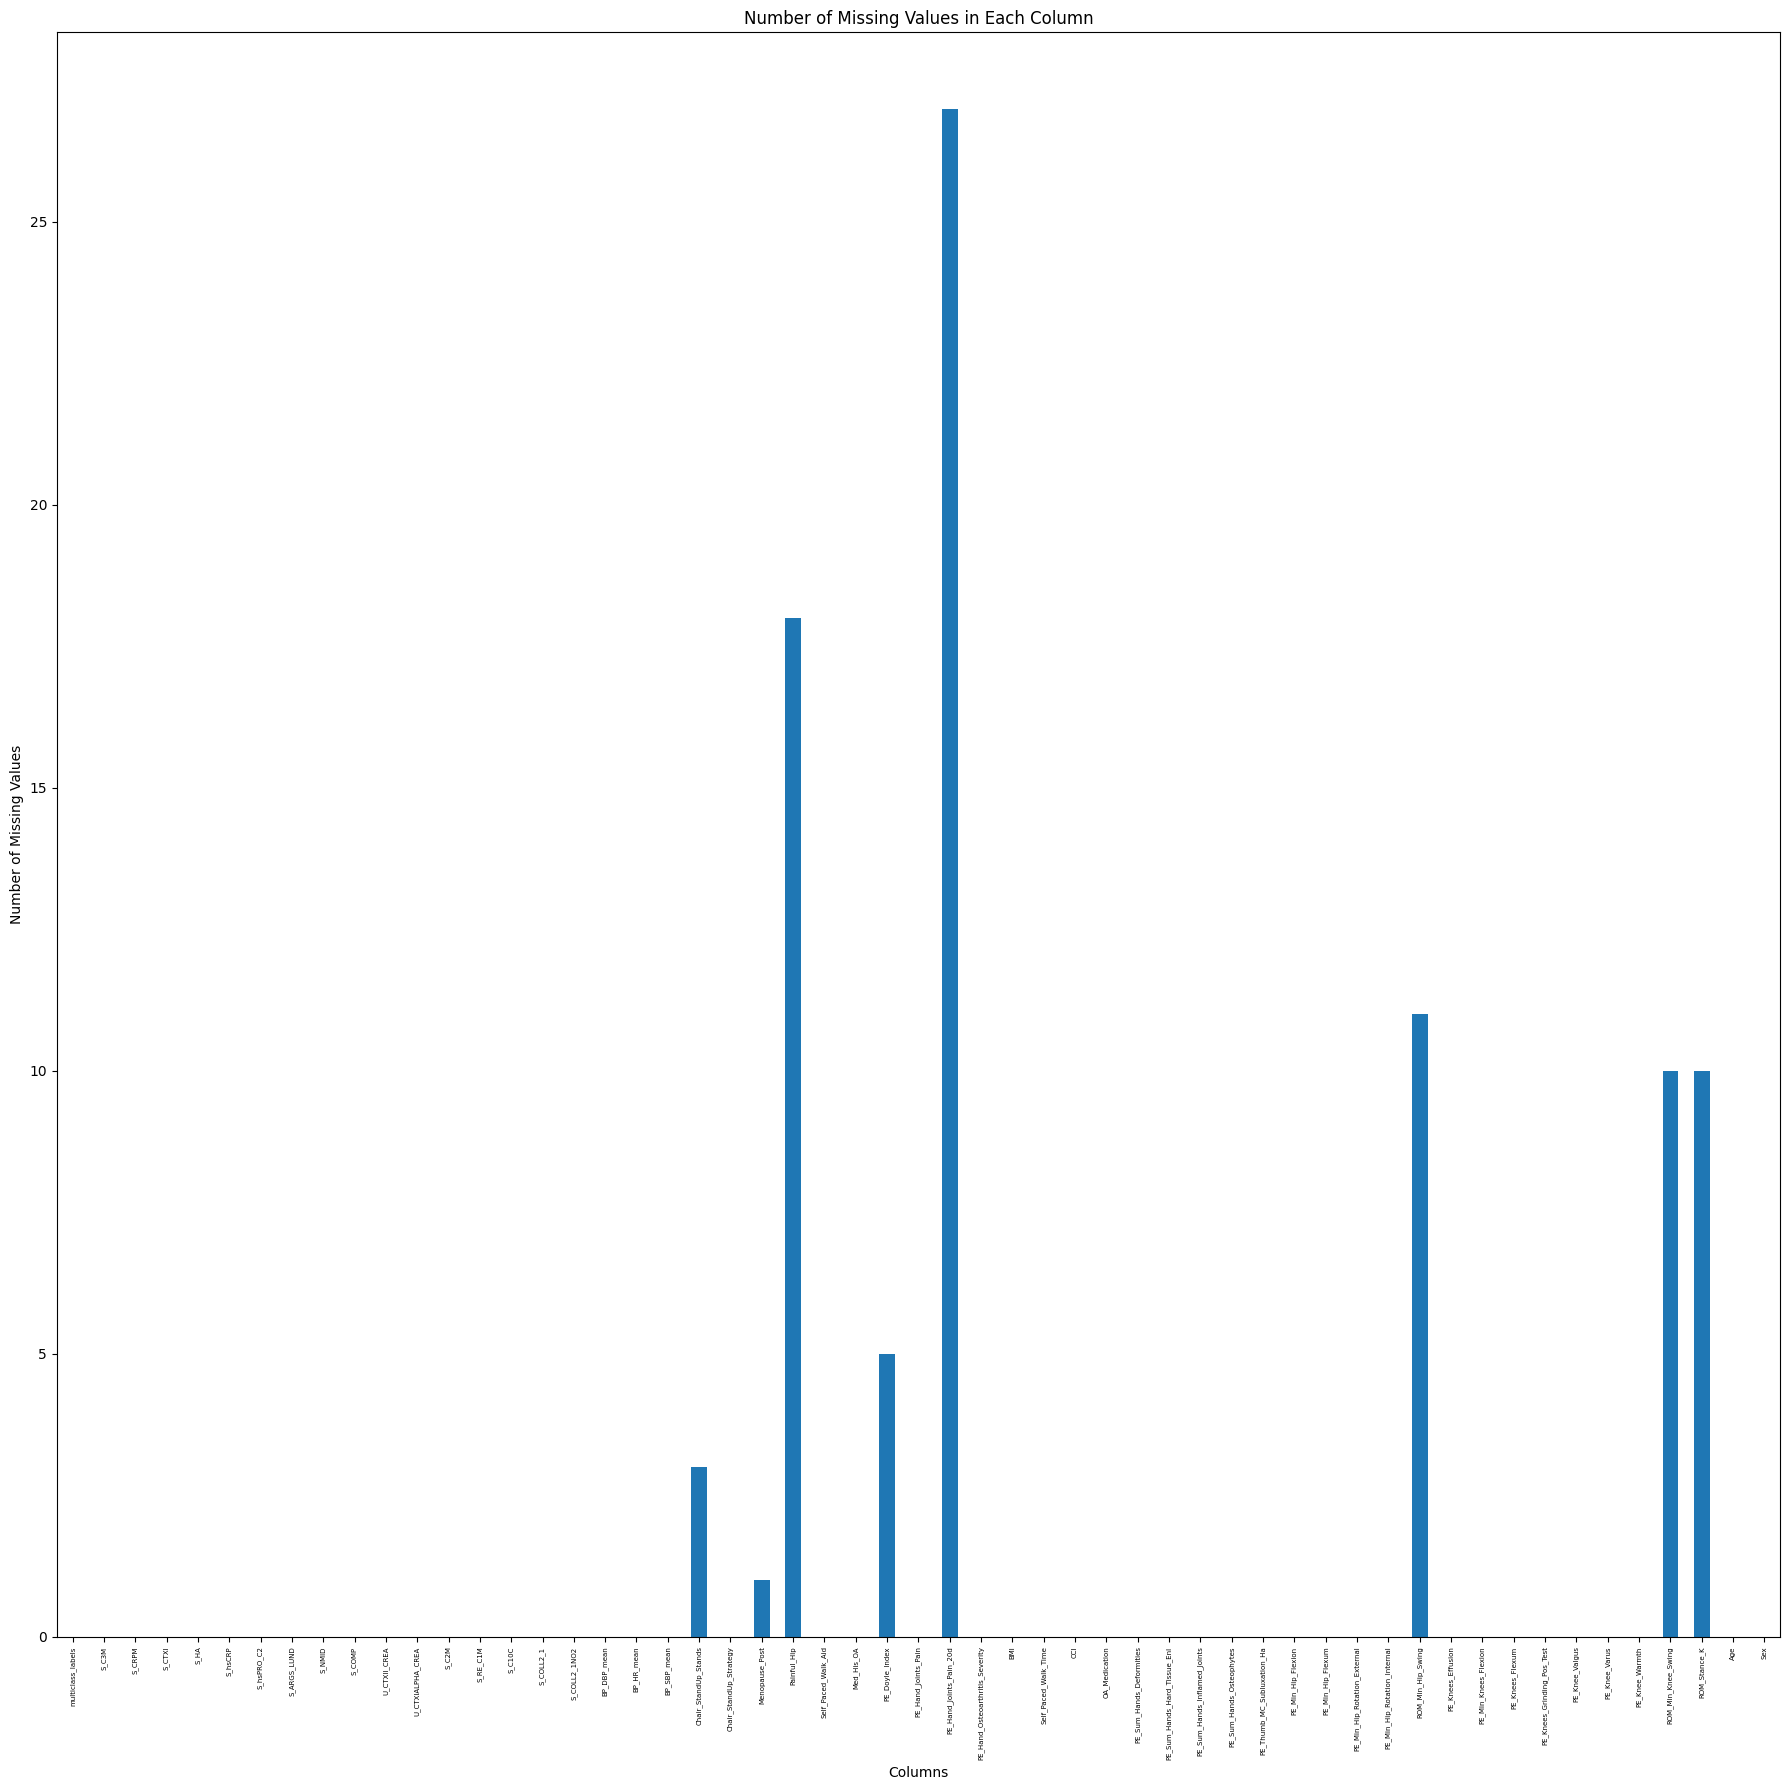

In [36]:
plt.figure(figsize=(18, 18))
merged_df.isnull().sum().plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation = 90, fontsize=5)
plt.tight_layout()
plt.show()

In [37]:
numerical_count = merged_df.select_dtypes(include=['int', 'float']).shape[1]
categorical_count = merged_df.select_dtypes(include=['object', 'category']).shape[1]

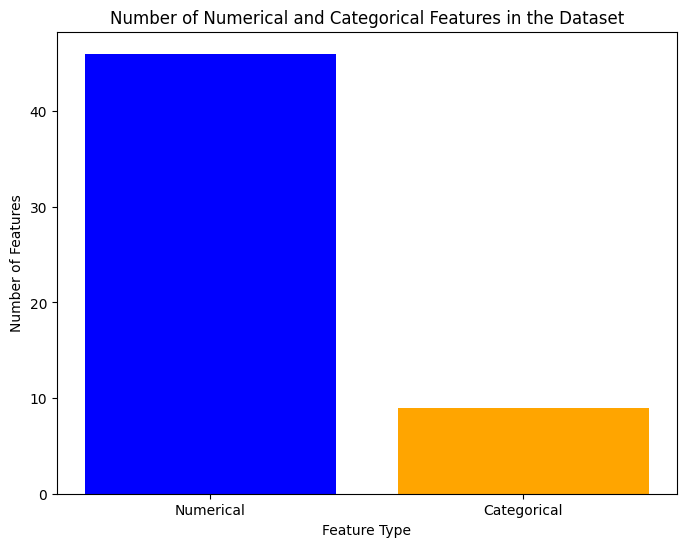

In [38]:
plt.figure(figsize=(8, 6))
plt.bar(['Numerical', 'Categorical'], [numerical_count, categorical_count], color=['blue', 'orange'])
plt.xlabel('Feature Type')
plt.ylabel('Number of Features')
plt.title('Number of Numerical and Categorical Features in the Dataset')
plt.show()

<Axes: >

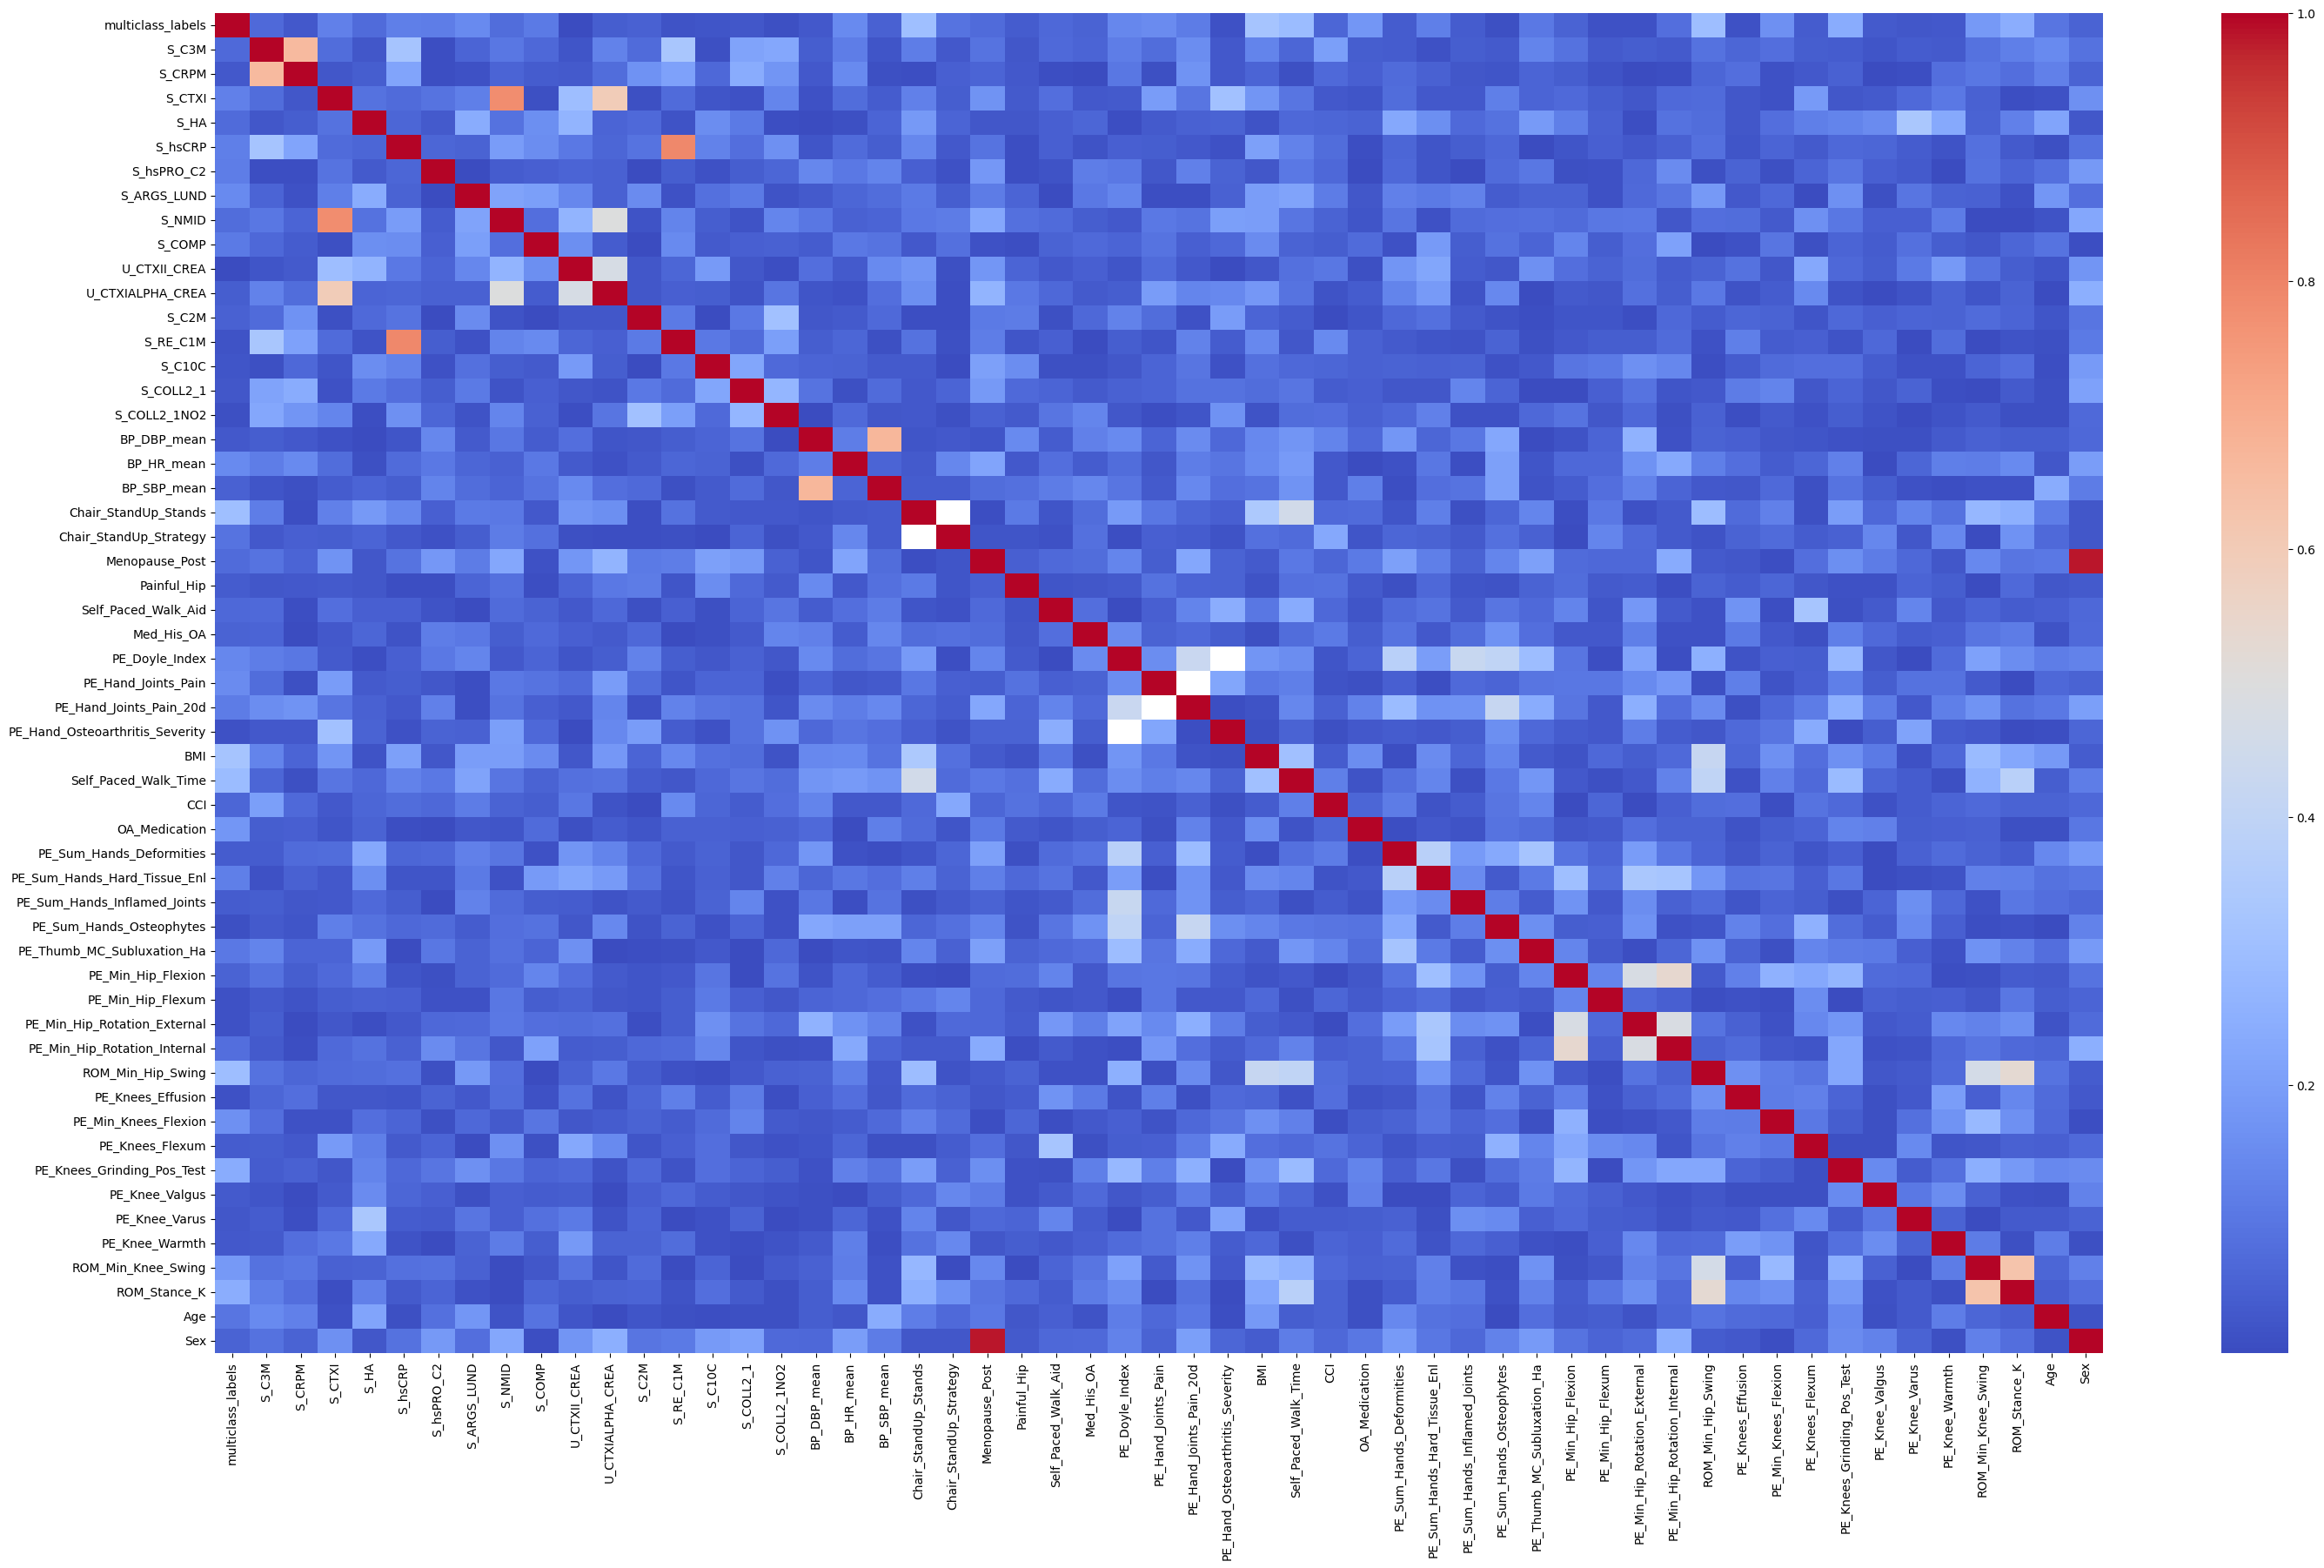

In [39]:
correlation_heatmap = merged_df.astype(float).corr().abs()
plt.figure(figsize = (35,20))
sns.heatmap(correlation_heatmap,annot=False,cmap = 'coolwarm')

In [40]:
summary_stats = merged_df.describe()
summary_stats

,multiclass_labels,S_C3M,S_CRPM,S_CTXI,S_HA,S_hsCRP,S_hsPRO_C2,S_ARGS_LUND,S_NMID,S_COMP,...,PE_Knees_Effusion,PE_Min_Knees_Flexion,PE_Knees_Flexum,PE_Knees_Grinding_Pos_Test,PE_Knee_Valgus,PE_Knee_Varus,PE_Knee_Warmth,ROM_Min_Knee_Swing,ROM_Stance_K,Age
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,...,221.0,221.0,221.0,221.0,221.0,221.0,221.0,211.000000,211.000000,221.000000
mean,0.882353,12.055204,10.702715,0.487557,91.086878,2.404072,23.574208,0.163394,22.029502,13.595928,...,0.239819,2.687783,0.131222,0.38914,0.122172,0.054299,0.054299,16.732227,16.562559,66.361991
std,1.002137,3.958814,3.656351,0.189097,91.620796,3.807795,14.951200,0.046659,7.772594,4.103284,...,0.523492,0.502073,0.432722,0.648544,0.455778,0.246322,0.22712,4.913761,5.191932,6.954737
min,0.000000,5.600000,3.200000,0.070000,20.000000,0.100000,12.400000,0.070000,6.440000,5.100000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.300000,2.000000,44.000000
25%,0.000000,9.700000,8.400000,0.340000,44.100000,0.600000,19.200000,0.140000,16.710000,10.800000,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,13.300000,13.600000,62.000000
50%,0.000000,11.400000,10.200000,0.470000,66.500000,1.200000,21.800000,0.160000,20.960000,13.000000,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17.000000,16.600000,67.000000
75%,2.000000,13.300000,12.400000,0.590000,107.500000,2.700000,24.600000,0.180000,27.140000,15.700000,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,20.200000,20.400000,71.000000
max,3.000000,38.700000,34.100000,1.130000,800.000000,37.600000,219.200000,0.550000,51.790000,30.500000,...,2.0,3.0,2.0,2.0,2.0,2.0,1.0,29.100000,33.300000,82.000000


#**Pre-processing**

In [41]:
merged_df.dropna(axis=1, thresh=0.6 * merged_df.shape[0], inplace=True)
merged_df = merged_df.loc[:, merged_df.apply(lambda column: column.nunique() > 1)]

In [42]:
merged_df.shape

(221, 55)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(merged_df.drop(columns=['multiclass_labels']),merged_df['multiclass_labels'],test_size = 0.2)

In [44]:
X_train_column_names = X_train.columns.tolist()
X_train_numerical_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
X_train_categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()


In [45]:
X_train_categorical_feature_indices = [X_train.columns.get_loc(col) for col in X_train_categorical_features]

In [46]:
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(63, 22)

In [47]:
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer()), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_train_numerical_features),
        ("cat", categorical_transformer, X_train_categorical_features),
    ]
)

In [48]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [49]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns = X_train_column_names )
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns = X_train_column_names)

In [50]:
X_train_preprocessed.isnull().sum().sum(), X_test_preprocessed.isnull().sum().sum()

(0, 0)

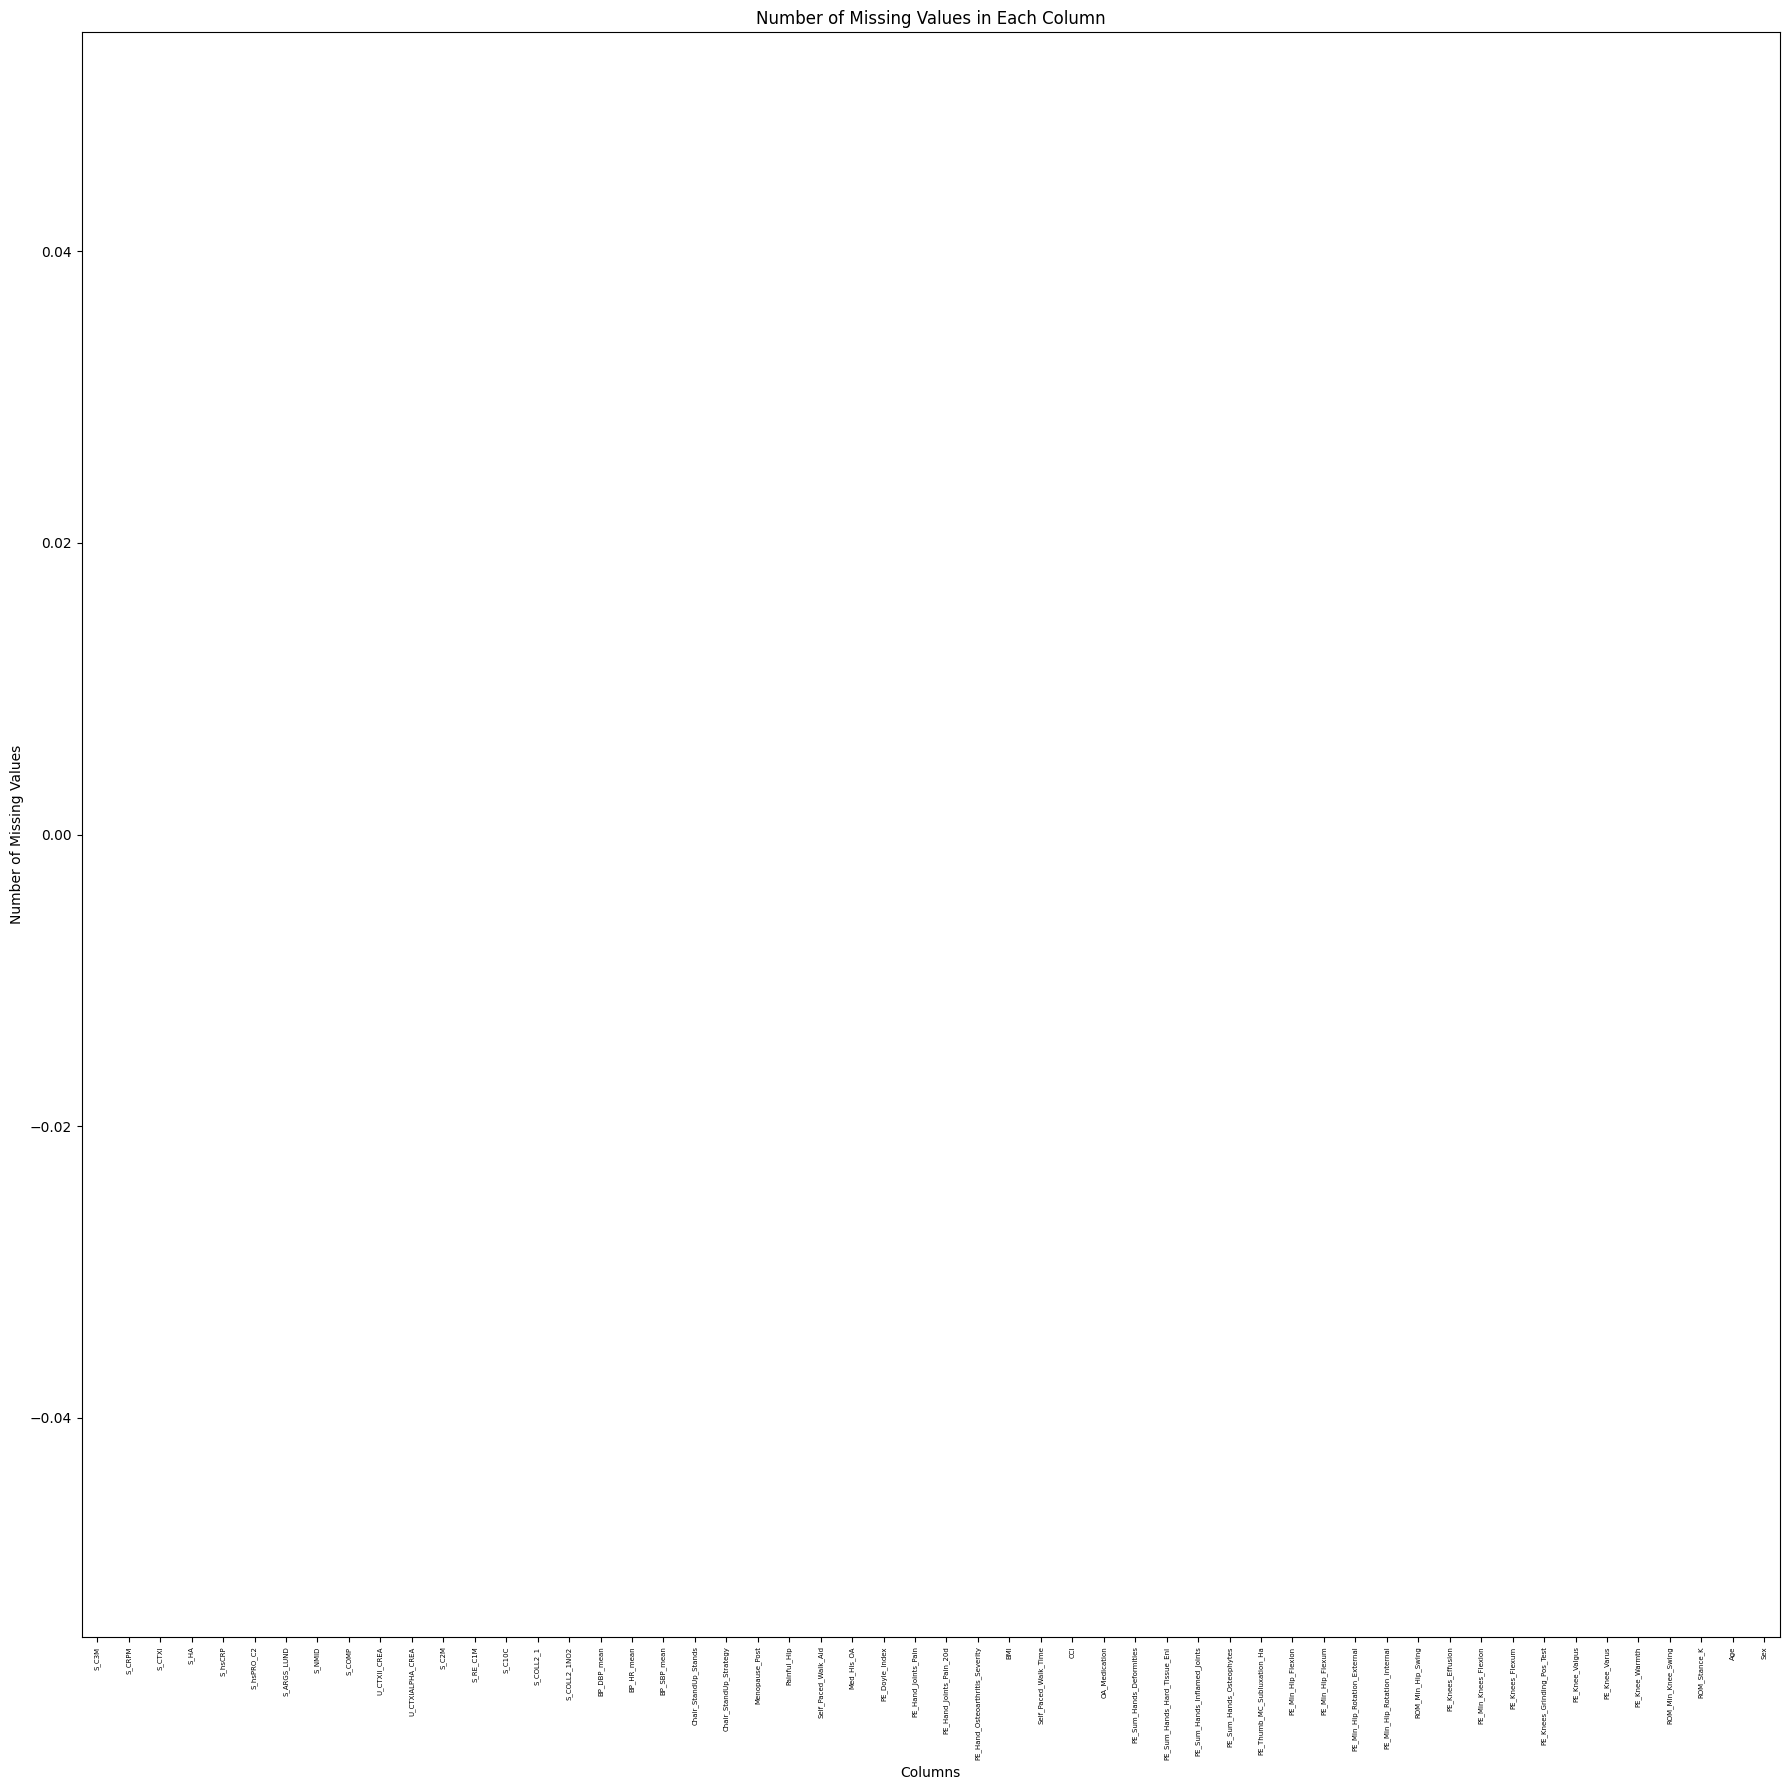

In [51]:
plt.figure(figsize=(18, 18))
X_test_preprocessed.isnull().sum().plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation = 90, fontsize=5)
plt.tight_layout()
plt.show()

#**Oversampling**

In [52]:
y_train.value_counts()

0    95
2    49
1    23
3     9
Name: multiclass_labels, dtype: int64

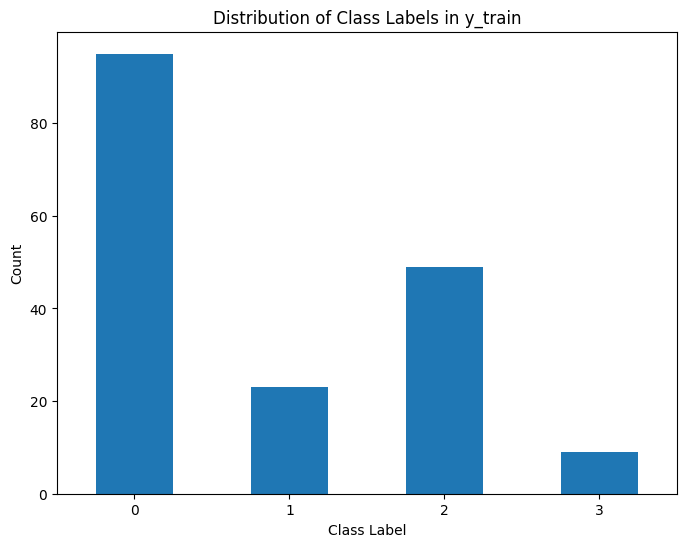

In [53]:
plt.figure(figsize=(8, 6))
y_train.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Labels in y_train')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [54]:
oversample = SMOTENC(categorical_features=X_train_categorical_feature_indices, random_state=42)
X_train_preprocessed_balanced, y_train_balanced = oversample.fit_resample(X_train_preprocessed, y_train)


In [55]:
y_train_balanced.value_counts()

0    95
2    95
1    95
3    95
Name: multiclass_labels, dtype: int64

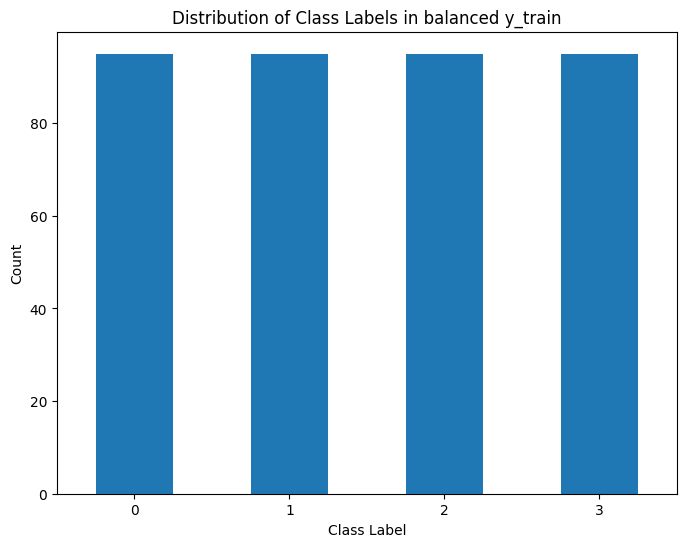

In [56]:
plt.figure(figsize=(8, 6))
y_train_balanced.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Labels in balanced y_train')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#**One hot encoding**

In [57]:
def perform_one_hot_encoding(data1,data2, categorical_columns):
  encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
  encoded_columns1 = encoder.fit_transform(data1[categorical_columns])
  encoded_columns2 = encoder.transform(data2[categorical_columns])
  encoded_data1 = pd.DataFrame(encoded_columns1, columns=encoder.get_feature_names_out(categorical_columns))
  encoded_data2 = pd.DataFrame(encoded_columns2, columns=encoder.get_feature_names_out(categorical_columns))
  print(encoded_data1.shape)
  data1 = data1.drop(columns=categorical_columns)
  data2 = data2.drop(columns=categorical_columns)
  data1 = pd.concat([data1, encoded_data1], axis=1)
  data2 = pd.concat([data2, encoded_data2], axis=1)
  return data1,data2

In [58]:
X_train_preprocessed_balanced_encoded, X_test_preprocessed_encoded = perform_one_hot_encoding(X_train_preprocessed_balanced,X_test_preprocessed, X_train_categorical_features)


(380, 200)


In [59]:
X_train_preprocessed_balanced_encoded.shape, X_test_preprocessed_encoded.shape

((380, 245), (45, 245))

# **Feature selection using correlation**

In [60]:
def highly_correlated(df):
  correlations = df.astype(float).corr().abs()
  mask = np.triu(np.ones(correlations.shape), k=1).astype(bool)
  correlations.where(mask, inplace=True)
  print("Correlation Matrix:")
  print(correlations)
  columns_to_drop = [i for i in correlations if any(abs(correlations[i]) >= 0.7)]
  df.drop(columns=columns_to_drop, inplace=True)
  plt.figure(figsize = (35,20))
  sns.heatmap(correlations,annot=False,cmap = 'coolwarm')
  return(df)

Correlation Matrix:
                   S_C3M   S_CRPM    S_CTXI      S_HA   S_hsCRP  S_hsPRO_C2  \
S_C3M                NaN  0.59716  0.140453  0.048510  0.322591    0.040588   
S_CRPM               NaN      NaN  0.155330  0.004124  0.337156    0.043087   
S_CTXI               NaN      NaN       NaN  0.141039  0.209635    0.046008   
S_HA                 NaN      NaN       NaN       NaN  0.089394    0.026584   
S_hsCRP              NaN      NaN       NaN       NaN       NaN    0.070902   
...                  ...      ...       ...       ...       ...         ...   
OA_Medication_0.0    NaN      NaN       NaN       NaN       NaN         NaN   
OA_Medication_0.5    NaN      NaN       NaN       NaN       NaN         NaN   
OA_Medication_1.0    NaN      NaN       NaN       NaN       NaN         NaN   
Sex_1                NaN      NaN       NaN       NaN       NaN         NaN   
Sex_2                NaN      NaN       NaN       NaN       NaN         NaN   

                   S_ARGS_LUND 

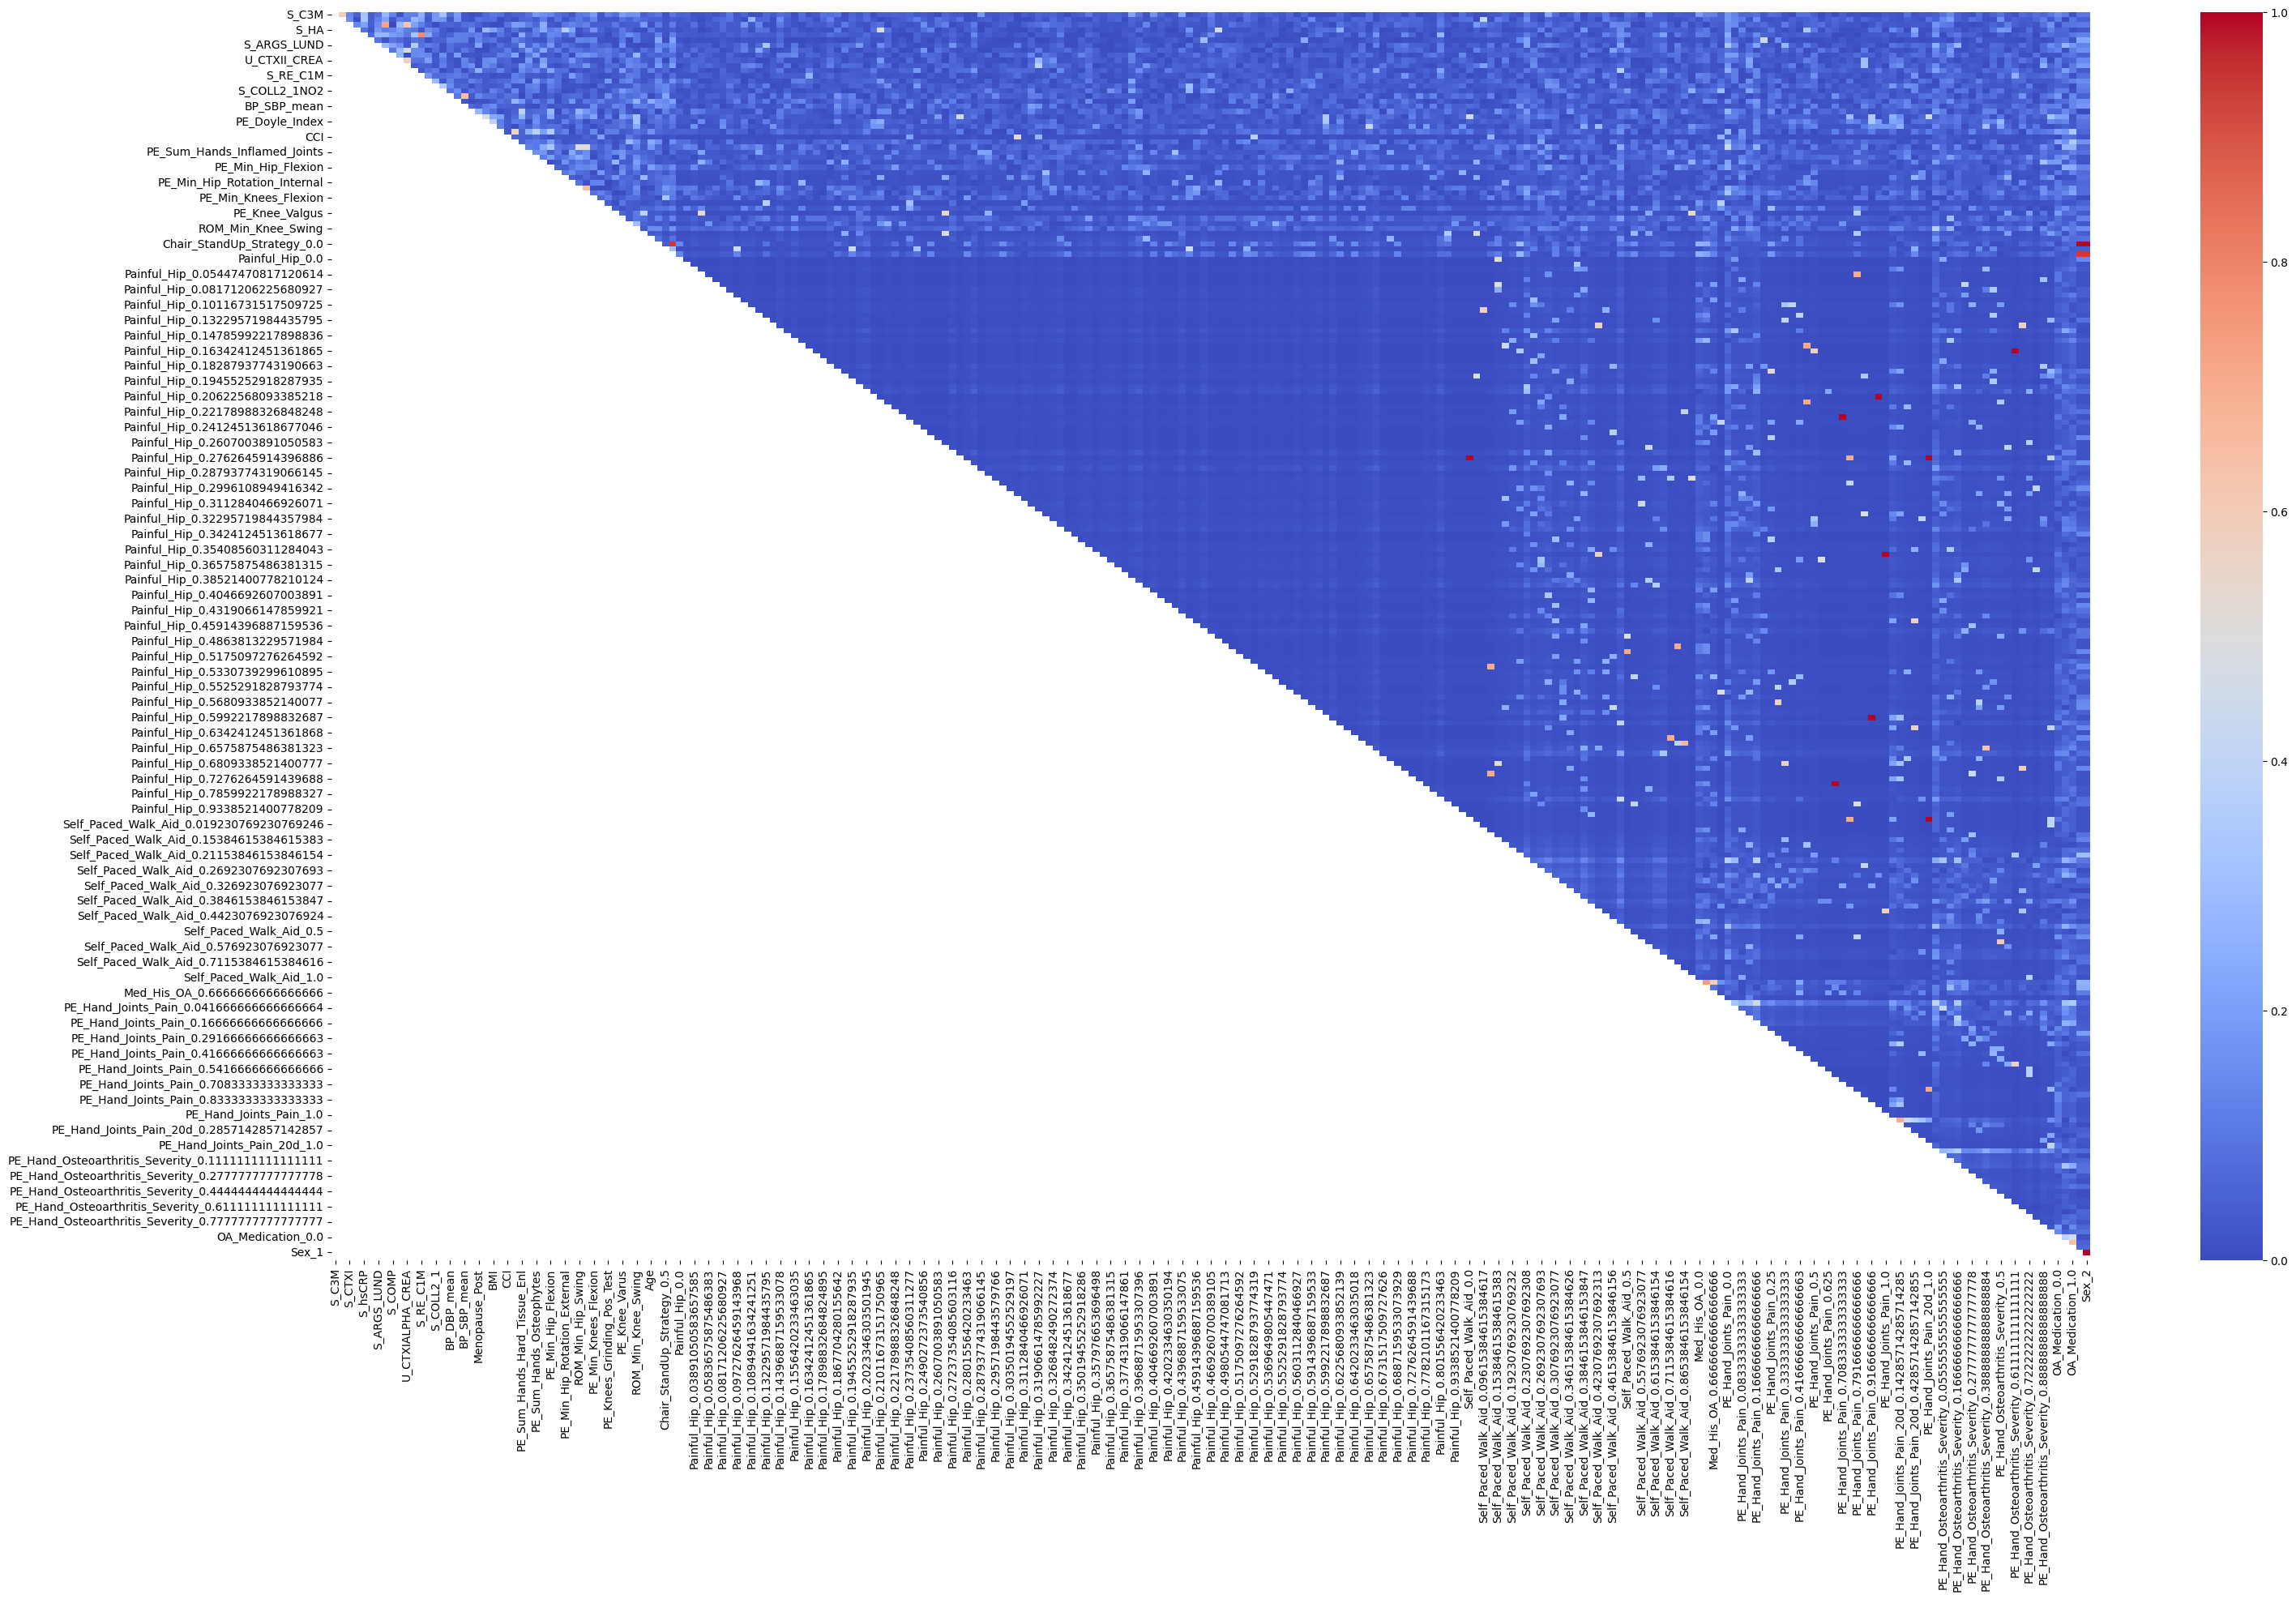

In [61]:
X_train_preprocessed_balanced_encoded_corr = highly_correlated(X_train_preprocessed_balanced_encoded)

<Axes: >

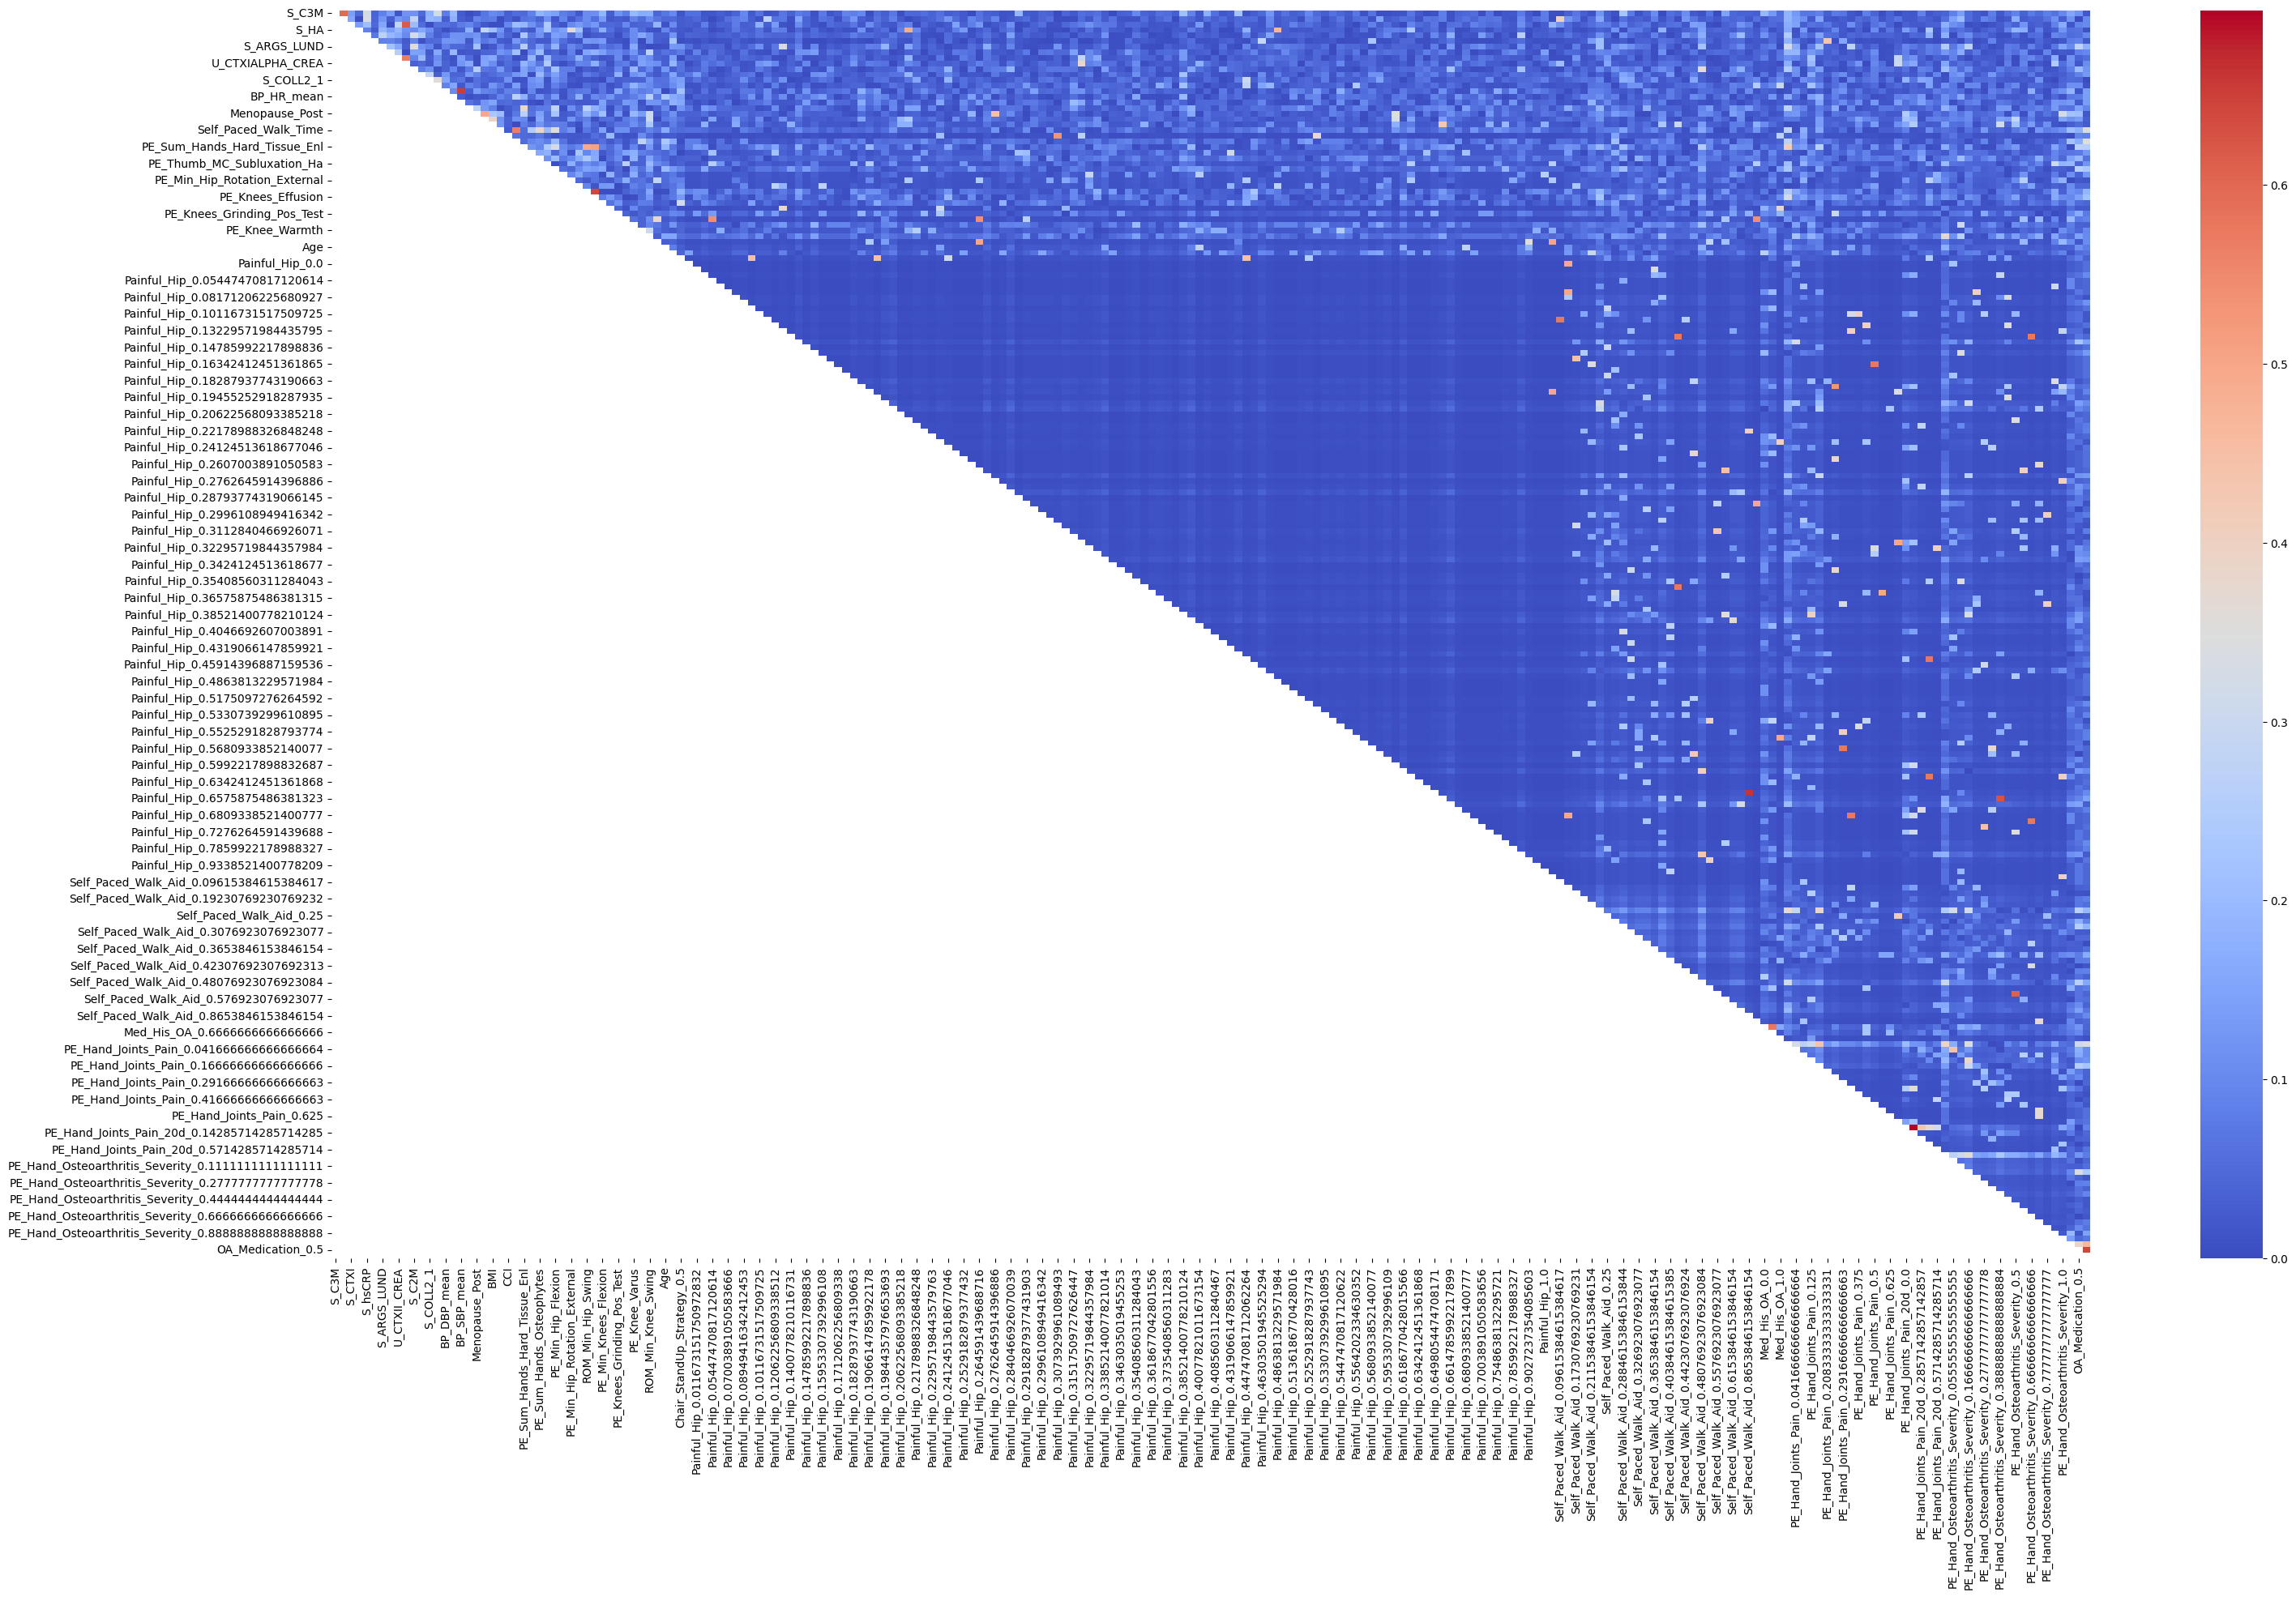

In [62]:
correlation_new = X_train_preprocessed_balanced_encoded_corr.astype(float).corr().abs()
mask = np.triu(np.ones(correlation_new.shape), k=1).astype(bool)
correlation_new.where(mask, inplace=True)
plt.figure(figsize = (35,20))
sns.heatmap(correlation_new,annot=False,cmap = 'coolwarm')

In [63]:
X_train_preprocessed_balanced_encoded_corr.shape

(380, 224)

In [64]:
column_names_final  = X_train_preprocessed_balanced_encoded_corr.columns.tolist()

In [65]:
X_test_preprocessed_encoded_corr = X_test_preprocessed_encoded[column_names_final]

In [66]:
X_train_preprocessed_balanced_encoded_corr.shape,X_test_preprocessed_encoded_corr.shape,y_train_balanced.shape,y_test.shape

((380, 224), (45, 224), (380,), (45,))

**Machine Learning Pipeline**

In [67]:
def knnModel(X_train, X_test, y_train, y_test):
  knn_clf = KNeighborsClassifier()
  inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  knn_param_grid = {'n_neighbors': [3, 5, 7,11,15,20]}
  knn_search = HalvingGridSearchCV(knn_clf, knn_param_grid, cv=inner_cv)
  knn_search.fit(X_train, y_train)
  knn_pred = knn_search.predict(X_test)
  knn_accuracy = accuracy_score(y_test, knn_pred)
  knn_f1_macro = f1_score(y_test, knn_pred, average='macro')
  selected_features_list = []

  perm_importance = permutation_importance(knn_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
  feature_importances = perm_importance.importances_mean
  num_features_to_select = 5
  important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
  selected_features = X_train.columns[important_feature_indices]
  selected_features_list.append(selected_features)
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]
  clf_selected = knn_search.best_estimator_
  clf_selected.fit(X_train_selected, y_train)
  results_df = pd.DataFrame({
        'Classifier': "KNN",
        'Accuracy': knn_accuracy,
        'Weighted F1 Score': knn_f1_macro,
        'Best Params': knn_search.best_params_
  })
  explainer_knn = shap.KernelExplainer(clf_selected.predict, X_train_selected)
  shap_values_knn = explainer_knn.shap_values(X_test_selected)
  shap.summary_plot(shap_values_knn, X_test_selected, feature_names=X_test_selected.columns)
  return results_df,selected_features_list

  0%|          | 0/45 [00:00<?, ?it/s]

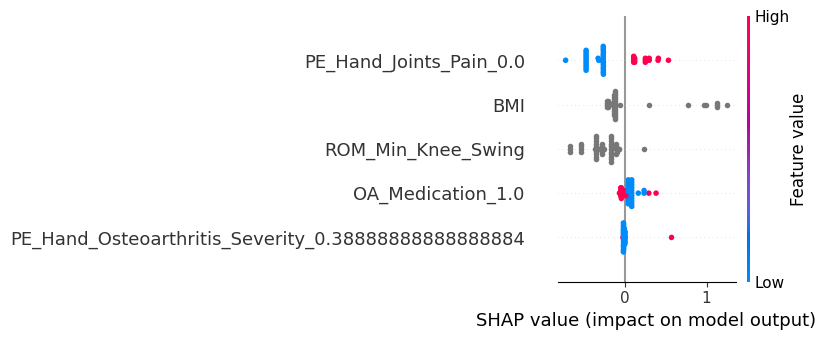

(            Classifier  Accuracy  Weighted F1 Score  Best Params
 n_neighbors        KNN  0.355556            0.27983            3,
 [Index(['BMI', 'PE_Hand_Joints_Pain_0.0', 'OA_Medication_1.0',
         'PE_Hand_Osteoarthritis_Severity_0.38888888888888884',
         'ROM_Min_Knee_Swing'],
        dtype='object')])

In [68]:
knnModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)

In [69]:
def randomForestModel(X_train, X_test, y_train, y_test):
    rf_clf = RandomForestClassifier()
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    rf_param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [None, 10, 20, 30, 40, 50]}
    rf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=inner_cv)
    rf_search.fit(X_train, y_train)
    rf_pred = rf_search.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_f1_macro = f1_score(y_test, rf_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(rf_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = rf_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Random Forest",
        'Accuracy': rf_accuracy,
        'F1 Score Macro': rf_f1_macro,
        'Best Params': [rf_search.best_params_]
    })

    explainer_rf = shap.TreeExplainer(clf_selected)
    shap_values_rf = explainer_rf.shap_values(X_test_selected)
    shap.summary_plot(shap_values_rf[0], X_test_selected, feature_names=X_test_selected.columns)

    return results_df,selected_features_list




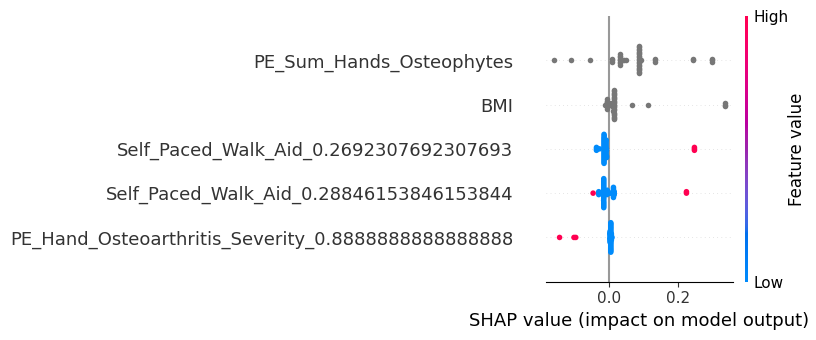

(      Classifier  Accuracy  F1 Score Macro  \
0  Random Forest  0.422222        0.227451   

                              Best Params  
0  {'max_depth': 50, 'n_estimators': 300}  , [Index(['Self_Paced_Walk_Aid_0.2692307692307693', 'BMI',
       'PE_Sum_Hands_Osteophytes', 'Self_Paced_Walk_Aid_0.28846153846153844',
       'PE_Hand_Osteoarthritis_Severity_0.8888888888888888'],
      dtype='object')])


In [70]:
results = randomForestModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)

In [71]:
def annModel(X_train, X_test, y_train, y_test):
    ann_clf = MLPClassifier(max_iter=1000)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ann_param_grid = {'hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)]}
    ann_search = HalvingGridSearchCV(ann_clf, ann_param_grid, cv=inner_cv)
    ann_search.fit(X_train, y_train)
    ann_pred = ann_search.predict(X_test)
    ann_accuracy = accuracy_score(y_test, ann_pred)
    ann_f1_macro = f1_score(y_test, ann_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(ann_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = ann_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Artificial Neural Network",
        'Accuracy': ann_accuracy,
        'F1 Score Macro': ann_f1_macro,
        'Best Params': [ann_search.best_params_]
    })

    explainer_ann = shap.KernelExplainer(clf_selected.predict_proba, X_train_selected)
    shap_values_ann = explainer_ann.shap_values(X_test_selected)
    shap.summary_plot(shap_values_ann, X_test_selected, feature_names=X_test_selected.columns)

    return results_df,selected_features_list

  0%|          | 0/45 [00:00<?, ?it/s]

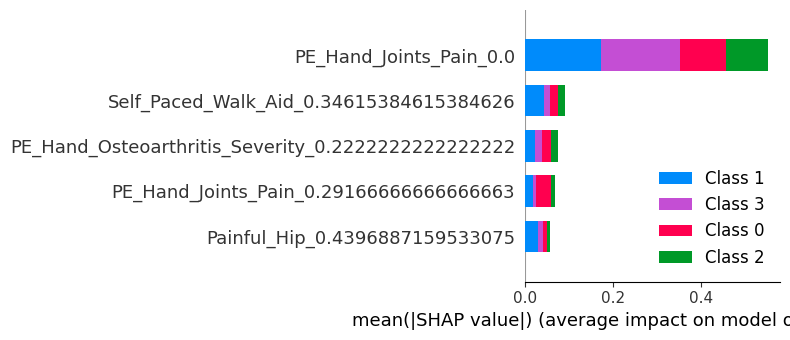

(                  Classifier  Accuracy  F1 Score Macro  \
0  Artificial Neural Network  0.422222        0.285139   

                            Best Params  
0  {'hidden_layer_sizes': (30, 30, 30)}  , [Index(['PE_Hand_Joints_Pain_0.0',
       'PE_Hand_Osteoarthritis_Severity_0.2222222222222222',
       'PE_Hand_Joints_Pain_0.29166666666666663',
       'Self_Paced_Walk_Aid_0.34615384615384626',
       'Painful_Hip_0.4396887159533075'],
      dtype='object')])


In [72]:
results = annModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)

In [74]:
def decisionTreeModel(X_train, X_test, y_train, y_test):
    dt_clf = DecisionTreeClassifier(max_depth=10)  # You can adjust max_depth as needed
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    dt_param_grid = {'max_depth': [None, 10, 20, 30, 40, 50]}
    dt_search = HalvingGridSearchCV(dt_clf, dt_param_grid, cv=inner_cv)
    dt_search.fit(X_train, y_train)
    dt_pred = dt_search.predict(X_test)
    dt_accuracy = accuracy_score(y_test, dt_pred)
    dt_f1_macro = f1_score(y_test, dt_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(dt_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = dt_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Decision Tree",
        'Accuracy': dt_accuracy,
        'F1 Score Macro': dt_f1_macro,
        'Best Params': [dt_search.best_params_]
    })

    explainer_dt = shap.TreeExplainer(clf_selected)
    shap_values_dt = explainer_dt.shap_values(X_test_selected)
    shap.summary_plot(shap_values_dt[0], X_test_selected, feature_names=X_test_selected.columns)

    return results_df, selected_features_list


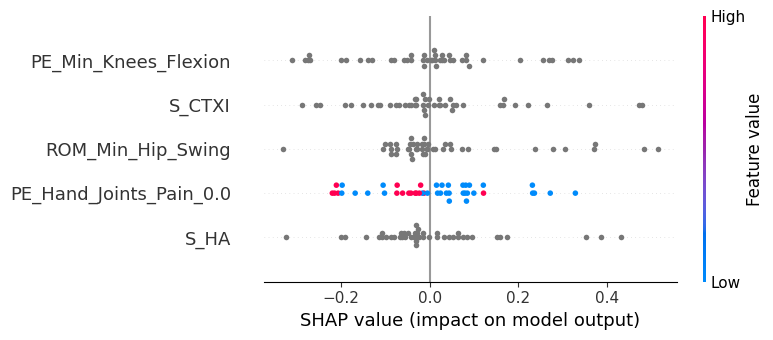

(      Classifier  Accuracy  F1 Score Macro        Best Params
0  Decision Tree  0.377778        0.270971  {'max_depth': 40}, [Index(['PE_Hand_Joints_Pain_0.0', 'S_HA', 'S_CTXI', 'PE_Min_Knees_Flexion',
       'ROM_Min_Hip_Swing'],
      dtype='object')])


In [75]:
results = decisionTreeModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)